In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return

In [2]:
import pandas as pd
import numpy as np

In [3]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False)

2020-11-05 21:17:50,143	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '155.198.195.98',
 'raylet_ip_address': '155.198.195.98',
 'redis_address': '155.198.195.98:6379',
 'object_store_address': '/tmp/ray/session_2020-11-05_21-17-49_651122_74724/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-05_21-17-49_651122_74724/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-11-05_21-17-49_651122_74724',
 'metrics_export_port': 48255}

In [27]:

def load_data(price_source='csvdata',tickers=['EEM','QQQ'],start='2008-01-02',end='2010-01-02'):
    '''Returned price data to use in gym environment'''
    # Load data 
    # Each dataframe will have columns date and a collection of fields 
    # TODO: DataLoader from mongoDB 
    # Raw price from DB, forward impute on the trading days for missing date 
    # calculate the features (log return, volatility)
    if price_source in ['csvdata']:
        feature_df = []
        price_tensor = []
        for t in tickers:
            df1 = pd.read_csv('csvdata/{}.csv'.format(t)).set_index('date').loc[start:end]
            feature_df.append(df1)
            price_tensor.append(df1['return']) # assumed to the be log return of the ref price
            ref_df_columns = df1.columns
    
    # assume all the price_df are aligned and cleaned in the DataLoader 
    merged_df = pd.concat(feature_df, axis=1, join='outer')
    price_tensor = np.vstack(price_tensor).transpose()
        
    return {'dates':merged_df.index, 'fields':ref_df_columns, 'pricedata':price_tensor, 'data':merged_df.values }
        

In [42]:
class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {'current_price':next_day_log_return}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation 
    
    # 0.05% t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995
        tcost = turnover * np.log(fees)
        return tcost 

In [43]:
config = {'pricing_source':'csvdata', 'tickers':['QQQ','EEM','TLT','SHY','GLD','SLV'], 'lookback':1, 'start':'2008-01-02', 'end':'2018-12-31'}
EQ_env = Equitydaily(config)

In [44]:
EQ_env.observation

array([[-1.51466979e-02, -3.48642883e-02,  1.31191573e-02,
         8.77396939e-02,  1.76832207e+00, -1.66375639e-02,
        -4.31632795e-02,  2.43134513e-02, -4.47693134e-03,
         1.57014939e+00,  1.42448827e-02,  3.77992193e-02,
         1.08146439e-02,  2.64748119e-01,  1.92618336e+00,
         1.82437466e-03,  5.83718797e-03,  1.86332113e-03,
         3.50909456e-02,  1.56583289e+00,  2.86895125e-02,
         5.72277346e-02,  1.41471329e-02, -6.38264232e-01,
         2.10516311e+00,  3.23353806e-02,  4.83851079e-02,
         1.57952239e-02, -5.01940672e-01,  2.14978441e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

[[ 3.36386621e-03 -3.64649043e-02  1.31130912e-02  1.12551912e-01
   1.26263200e+00  8.95851848e-03 -3.93750850e-02  2.44133875e-02
  -7.91718862e-03  1.16164833e+00 -1.37818845e-03  4.52287319e-02
   1.08190566e-02  2.74691817e-01  8.26520747e-01  1.57588573e-03
   8.38735392e-03  1.88984133e-03 -3.56933923e-02  4.48475797e-01
   8.33191466e-03  4.84863655e-02  1.39849102e-02 -7.23249049e-01
   1.56131299e+00  6.89318338e-03  4.60559272e-02  1.56318398e-02
  -5.45955954e-01  1.62022320e+00  1.18180806e-03  1.60463965e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.00336387,  0.00895852, -0.00137819,  0.00157589,  0.00833191,
        0.00689318])}
[[-4.48473284e-02 -7.03961673e-02  1.58505831e-02 -8.59706127e-02
   2.02409598e+00 -3.04976987e-02 -4.65257342e-02  2.29568619e-02
   7.44256938e-02  1.89779991e+00  2.13230071e-04  3.46457735e-02
   1.04480781e-02  2.64342955e-01  1.5743698

[[-3.93253841e-03 -1.15489643e-02  1.34413969e-02  5.93421046e-01
   8.48747869e-01 -8.19599303e-03 -1.77989375e-02  1.41638474e-02
   1.42854961e-01  8.80782186e-01  3.68283034e-03  9.66870612e-03
   6.45372834e-03  1.76179803e-02  7.92297713e-01  3.60458412e-04
   4.09096043e-03  1.27261214e-03 -4.85532073e-01  9.62731862e-01
   2.06114810e-03  3.30262574e-02  1.41493730e-02 -3.96089323e-01
   8.96038010e-01 -2.09800766e-03  2.47871265e-02  1.99920130e-02
  -4.39060981e-01  1.02279594e+00 -1.96626921e-03 -8.74317365e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.00393254, -0.00819599,  0.00368283,  0.00036046,  0.00206115,
       -0.00209801])}
[[ 0.01808832  0.00941412  0.01361411  0.58290421  0.77117147  0.01277364
  -0.00429008  0.01428416  0.14119759  0.83288802 -0.001515    0.0081537
   0.00637159  0.02228912  0.7456132  -0.00192209  0.00108385  0.00132254
  -0.51519117  0.6481

[[-0.02127436 -0.08120602  0.04092623  0.72136755  0.99693319 -0.01678852
  -0.12946291  0.09082704  0.60229556  0.76711775  0.00440441  0.00914484
   0.01200443  0.07071593  0.40299845  0.00177923  0.0013041   0.00148979
  -0.09461959  0.5955388  -0.00890722 -0.01271986  0.02686446  0.47907342
   0.76848763 -0.01941809 -0.09153996  0.03137068 -0.70815722  0.87460054
  -0.01063718 -0.40642777  0.5         0.          0.          0.
   0.          0.          0.5       ]]
{'current_price': array([-0.02127436, -0.01678852,  0.00440441,  0.00177923, -0.00890722,
       -0.01941809])}
[[-1.05966978e-03 -6.02505853e-02  3.95229422e-02  6.94289413e-01
   1.20042709e+00 -1.47543129e-02 -7.98648255e-02  8.91628593e-02
   5.79651889e-01  7.31895721e-01  1.27854388e-02  1.89764164e-02
   1.22694057e-02  6.65520673e-02  8.05413550e-01  1.06548427e-03
   1.65731155e-03  1.45398315e-03 -8.38606343e-02  6.72972329e-01
  -1.92890663e-03  6.36416094e-03  2.60354795e-02  4.51036856e-01
   8.38569260e-0

[[-2.99765434e-03  7.66420912e-03  1.53032088e-02 -1.67423978e-01
   7.84868391e-01 -1.55903187e-02 -4.57768363e-02  2.38972351e-02
   5.71695359e-02  8.02981427e-01 -2.56338575e-03 -1.63808195e-02
   1.49868232e-02 -1.81656813e-01  6.54127619e-01 -2.64794441e-03
  -8.75788566e-03  1.83616843e-03 -2.05957340e+00  9.44621774e-01
  -1.60196542e-03 -2.29287872e-02  1.23741186e-02 -3.08088152e-01
   7.52112203e-01 -1.67958265e-02 -3.91946549e-02  2.19456592e-02
  -4.68075726e-01  1.14544027e+00 -1.49882717e-03 -2.71008835e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.00299765, -0.01559032, -0.00256339, -0.00264794, -0.00160197,
       -0.01679583])}
[[ 7.60894028e-03  1.38981442e-02  1.53315733e-02 -2.23809202e-01
   9.91938509e-01  1.80885476e-03 -2.94274211e-02  2.31026113e-02
   3.21122415e-02  7.84569937e-01 -1.11264787e-04 -2.18574823e-02
   1.44742116e-02 -1.59082824e-01  9.3238752

[[-5.62823125e-03  1.49643022e-02  8.29274414e-03 -3.85256861e-01
   8.00047764e-01 -1.03823434e-02  1.19653112e-02  1.50795095e-02
  -4.18740882e-01  7.33756176e-01 -4.45706630e-03 -1.95271744e-02
   5.74491484e-03 -2.55004485e-01  8.86545614e-01 -2.39506221e-04
  -3.47053534e-03  9.63424183e-04 -1.41033815e-01  8.32647906e-01
  -2.72170562e-04 -6.69201268e-03  1.37905702e-02 -9.47627012e-01
   5.86011634e-01  5.85308767e-04 -1.22130044e-02  1.61428237e-02
   4.00008417e-01  5.37322850e-01 -2.81411562e-03 -1.95679510e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.00562823, -0.01038234, -0.00445707, -0.00023951, -0.00027217,
        0.00058531])}
[[ 1.35346614e-03  6.33022048e-03  8.26460436e-03 -4.06632859e-01
   8.27722930e-01  5.80738219e-03  1.16486872e-02  1.51425087e-02
  -4.02159869e-01  7.38400131e-01 -1.19774057e-03 -1.61203986e-02
   5.51153203e-03 -3.06636051e-01  9.4661119

[[ 3.19360131e-03  4.29927623e-02  1.92487382e-02  2.35123614e-01
   8.68931000e-01 -5.01944336e-03  3.01436271e-02  2.63898307e-02
   5.86070438e-01  7.98504359e-01  8.10616233e-03  1.71106993e-02
   1.17342327e-02  2.03537869e-01  1.00709488e+00  5.95570414e-04
   1.66980257e-03  9.19850084e-04  6.16965535e-01  1.29893603e+00
   1.29630680e-02  2.42876495e-02  9.43786025e-03  1.75334114e-01
   1.31164614e+00  1.37327069e-02  2.59754864e-02  1.74519086e-02
  -1.86492901e-01  8.17090743e-01  1.59680066e-03 -1.75433472e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.0031936 , -0.00501944,  0.00810616,  0.00059557,  0.01296307,
        0.01373271])}
[[ 8.36367379e-04  3.43352087e-02  1.69397106e-02  2.40196447e-01
   8.92661965e-01  4.52018216e-03  2.94879602e-02  2.32260010e-02
   5.83186152e-01  7.92580424e-01 -1.63668050e-03  2.87031104e-03
   1.07650456e-02  2.14283244e-01  7.9004980

[[ 1.74827713e-03  9.51174448e-03  1.02870857e-02  1.72836314e-01
   1.28835392e+00  1.49160834e-03  2.55728118e-03  1.61213432e-02
  -4.57039117e-01  9.43437365e-01 -1.47058271e-02 -2.18461933e-02
   1.24632730e-02 -9.50882160e-02  1.67689932e+00 -4.77627334e-04
  -1.90524429e-03  9.33758852e-04 -6.24282772e-01  7.89071749e-01
   9.55074826e-04 -2.34707457e-03  9.59934466e-03 -3.56038707e-01
   1.00575190e+00 -2.08044458e-03  2.56649699e-02  2.30903354e-02
  -6.42747052e-01  6.65986298e-01  8.74138565e-04 -1.46963766e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.00174828,  0.00149161, -0.01470583, -0.00047763,  0.00095507,
       -0.00208044])}
[[-4.32940854e-03  1.47734391e-03  9.44705741e-03  5.23798842e-02
   1.43132267e+00 -1.63156608e-02 -7.33245361e-03  1.53431233e-02
  -3.85497270e-01  1.24303548e+00 -1.30551347e-02 -2.51914331e-02
   1.12294765e-02 -7.08630342e-02  1.7287888

[[ 0.00000000e+00 -2.26189469e-02  9.99162440e-03 -7.25352501e-02
   7.74795613e-01 -1.72375780e-03 -1.51903241e-02  1.21697789e-02
  -3.67540123e-01  7.38847315e-01 -5.05678431e-03  1.09230385e-02
   8.11848782e-03 -6.80540234e-01  5.96180998e-01 -3.55581670e-04
   2.35835836e-04  4.75838545e-04  1.51707547e-01  7.75010568e-01
  -9.89873744e-03 -1.81731741e-02  5.59396607e-03 -5.84027058e-01
   1.09009610e+00 -3.99358624e-02 -5.29010948e-02  2.62807543e-02
  -1.13030743e+00  1.16133439e+00  0.00000000e+00 -1.46739148e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.        , -0.00172376, -0.00505678, -0.00035558, -0.00989874,
       -0.03993586])}
[[ 1.27304606e-02 -8.09783747e-03  1.00259206e-02 -6.79040782e-02
   8.45057425e-01  1.49778971e-02 -8.03552943e-03  1.26516651e-02
  -3.73326099e-01  9.32471089e-01 -1.52211073e-02 -8.88984849e-03
   8.80486852e-03 -6.46116946e-01  9.1680911

[[ 5.11315420e-03 -3.56952666e-02  1.58828133e-02  2.11229972e-01
   1.13227317e+00  7.35704876e-03 -4.81309367e-02  2.52674520e-02
   2.37801598e-01  9.62205085e-01  1.15932750e-02  4.69474040e-02
   1.11634798e-02  3.12097468e-01  1.13347081e+00  4.72851721e-04
   1.17871648e-04  1.88217259e-04 -1.85669635e-01  1.34618273e+00
   1.88586679e-02 -6.94866403e-02  1.60707967e-02 -1.43297837e-01
   1.04655600e+00  2.20790465e-02 -8.24661120e-02  2.70070994e-02
  -2.64486116e-01  7.35480789e-01  2.55657710e-03 -1.47313793e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([0.00511315, 0.00735705, 0.01159327, 0.00047285, 0.01885867,
       0.02207905])}
[[-9.89339829e-03 -3.43005440e-02  1.59402240e-02  2.18898215e-01
   8.57826050e-01 -2.61932277e-02 -3.60052521e-02  2.58401041e-02
   2.46505078e-01  8.42905943e-01  1.25925802e-02  4.84632582e-02
   1.14330311e-02  2.38033702e-01  9.54107703e-01 

[[ 1.23225110e-02  4.17650255e-03  1.31315523e-02  3.28300479e-01
   8.04461014e-01  1.82452333e-02  2.75604810e-02  1.56025878e-02
   4.79461275e-01  1.21234335e+00  5.55381698e-03  9.45933165e-03
   1.12200168e-02  3.33343476e-01  5.26640144e-01  3.55920185e-04
  -1.17758644e-04  3.00369223e-04  1.22262866e-01  2.73545291e-01
   5.70360293e-04  1.99001992e-02  1.13605679e-02  1.01989358e+00
   1.07051251e+00 -3.59518249e-04  2.15982805e-03  1.38821518e-02
   3.43488329e-01  5.27586150e-01  6.16125548e-03 -1.31938055e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.01232251,  0.01824523,  0.00555382,  0.00035592,  0.00057036,
       -0.00035952])}
[[ 9.32310786e-03  3.05840525e-02  1.27993750e-02  3.17727589e-01
   6.78575479e-01  2.05144002e-03  4.40856279e-02  1.53720516e-02
   4.95249954e-01  7.50558684e-01  5.36473347e-03  1.02820407e-02
   1.12604270e-02  3.45272794e-01  5.7275282

[[ 1.29684204e-02  5.16786757e-03  8.72750692e-03 -1.57282537e-01
   1.03061668e+00  5.08031202e-03  3.19481566e-02  7.92135105e-03
  -3.82856037e-01  1.09179760e+00 -7.62990468e-03 -1.08255707e-02
   4.52721141e-03  3.00191609e-01  1.17110904e+00  0.00000000e+00
   2.37641372e-04  1.18295003e-04  7.10101607e-01  1.32279848e+00
  -9.05113955e-04  7.45299902e-03  6.20843729e-03 -7.03195895e-02
   5.91109462e-01 -7.19125414e-03  3.13430499e-04  1.19809788e-02
  -4.41502089e-01  6.00970083e-01  6.48421022e-03 -1.29046176e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.01296842,  0.00508031, -0.0076299 ,  0.        , -0.00090511,
       -0.00719125])}
[[-2.12412848e-03  1.41795092e-02  8.53175879e-03 -1.91060051e-01
   1.13650922e+00  2.99932951e-03  2.42866617e-02  7.43286756e-03
  -4.44203714e-01  1.09977544e+00 -1.16779931e-02 -2.20248644e-02
   5.02909949e-03  3.01853524e-01  1.9882388

[[ 1.77343402e-03 -4.09034067e-04  4.90213293e-03 -5.65102842e-01
   1.31155954e+00  1.48199500e-02 -1.08225167e-02  8.28346285e-03
  -3.15288246e-01  1.44974948e+00  5.27266293e-03 -1.50522135e-02
   9.33435345e-03 -5.25947439e-01  1.35142633e+00  3.20505661e-04
  -2.71902342e-04  2.43556759e-04 -9.46012774e-01  2.35411003e+00
   1.91552653e-02  2.03507227e-02  1.53118633e-02 -2.23531088e+00
   7.24391353e-01  2.50214030e-02  1.68903325e-02  1.87832191e-02
  -2.32483068e+00  7.04531798e-01  8.86717009e-04 -1.20315871e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([0.00177343, 0.01481995, 0.00527266, 0.00032051, 0.01915527,
       0.0250214 ])}
[[-5.19218018e-03 -1.21187227e-02  5.02689287e-03 -4.90690053e-01
   9.44721116e-01 -1.22739774e-02 -2.86424326e-02  8.54833633e-03
  -2.42601843e-01  8.29152714e-01 -9.27802989e-03  1.33869537e-03
   9.45694308e-03 -4.62771876e-01  6.42294184e-01 

[[ 5.21303368e-03  2.06533433e-02  7.15320197e-03 -3.12100005e-01
   9.70991355e-01  3.36932617e-03 -1.71383706e-02  1.04676312e-02
   6.45982078e-01  5.81582949e-01  3.73528005e-03  3.81764826e-04
   8.93125012e-03 -9.49420325e-01  8.85685259e-01  1.18374904e-04
   4.73583713e-04  3.16123610e-04  3.49637742e-01  5.20595319e-01
  -5.32713096e-03 -2.57871520e-02  8.16449185e-03  7.66701266e-01
   1.23826594e+00 -7.29169897e-03 -2.47818568e-02  1.28481786e-02
   3.92435112e-01  7.30508813e-01  2.60651684e-03 -1.10031524e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.00521303,  0.00336933,  0.00373528,  0.00011837, -0.00532713,
       -0.0072917 ])}
[[ 6.94690775e-03  3.00163529e-02  7.24168171e-03 -3.28925844e-01
   8.18213891e-01  6.46135854e-03  3.10612177e-03  1.05840776e-02
  -7.87668732e-02  7.22372352e-01 -1.72250446e-03  1.58294254e-02
   8.86768447e-03 -1.01435695e+00  8.0344063

[[-3.09217265e-03  3.04416433e-02  7.06042419e-03 -8.62952081e-01
   8.25612324e-01  5.82887323e-03  1.00468000e-02  7.03637972e-03
  -6.24908277e-01  8.61855836e-01  1.22749727e-02  1.58985338e-02
   6.39599622e-03 -8.09356726e-02  1.36275124e+00  2.36195276e-04
   0.00000000e+00  2.62785907e-04 -1.47147343e+00  1.17688941e+00
  -5.34870644e-03 -2.83885834e-02  7.68924233e-03 -6.03683971e-01
   1.30221136e+00 -4.36681917e-03 -2.00385801e-02  1.01376476e-02
   2.61881787e-01  1.04214897e+00 -1.54608633e-03 -1.07006346e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.00309217,  0.00582887,  0.01227497,  0.0002362 , -0.00534871,
       -0.00436682])}
[[ 6.37276640e-03  2.73142415e-02  7.12722178e-03 -8.81027865e-01
   8.79581372e-01  2.78583674e-03  5.11331053e-03  6.97977534e-03
  -6.45619448e-01  5.85835957e-01 -5.33019701e-03  1.66952579e-02
   6.57308856e-03 -1.59084736e-02  1.3730867

[[ 3.10442129e-03  1.58192402e-02  7.88177471e-03 -1.97986301e-01
   8.26877010e-01  8.23852868e-03  5.32338172e-03  7.61098909e-03
  -6.44614715e-02  1.12384473e+00  4.86593575e-03 -2.17312165e-03
   5.17167856e-03  5.42189528e-01  9.69314797e-01  4.72535020e-04
   2.36873024e-04  4.82999774e-04 -5.43602536e-02  4.52063161e-01
   2.47646865e-02  1.31904832e-02  1.35528780e-02  2.98200939e-01
   1.65068324e+00  4.31439460e-02  3.44974006e-02  1.92054664e-02
  -4.10444314e-02  2.11382034e+00  1.55221064e-03 -1.00047598e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([0.00310442, 0.00823853, 0.00486594, 0.00047254, 0.02476469,
       0.04314395])}
[[-3.00780809e-03  9.27412513e-03  7.74393646e-03 -1.68629393e-01
   1.04901518e+00 -1.06752536e-02 -8.01572517e-03  8.01484464e-03
  -6.62485416e-02  9.55304165e-01 -2.51407361e-03  4.54132200e-03
   5.09324071e-03  5.63638129e-01  9.73374199e-01 

[[ 0.00000000e+00  8.15572957e-03  9.30304988e-03 -5.21305266e-01
   8.02404997e-01  7.67716907e-03  6.50897377e-03  8.54637763e-03
  -2.94118411e-01  9.82181072e-01  1.98520757e-02 -7.53825917e-03
   1.09794002e-02 -2.22737379e-01  9.85192305e-01  0.00000000e+00
   5.88881753e-04  5.52848878e-04  8.20281670e-01  3.35075447e-01
   2.98240603e-03  3.07583643e-02  1.02247890e-02 -2.01467124e-01
   8.01083087e-01  5.98804184e-03  6.09231738e-02  1.63154710e-02
   6.08240489e-01  7.56742653e-01  0.00000000e+00 -9.90149219e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([0.        , 0.00767717, 0.01985208, 0.        , 0.00298241,
       0.00598804])}
[[ 4.37024929e-03  1.63977887e-02  8.79936287e-03 -6.07687325e-01
   6.02887057e-01 -1.02493791e-02  5.87137781e-03  8.87743203e-03
  -2.81553017e-01  8.48938280e-01 -1.69203284e-02  1.66508642e-04
   1.13177443e-02 -1.51972835e-01  7.89701763e-01 

[[-1.06843411e-02 -9.11528831e-03  9.62155213e-03 -3.73875018e-02
   1.17323788e+00 -2.52437729e-02 -3.25825326e-02  1.35979690e-02
  -6.32679011e-02  1.10390697e+00 -5.64656803e-03 -3.01340804e-02
   7.15629904e-03 -1.72433892e-01  1.01455416e+00 -2.37295539e-04
  -2.36286902e-03  6.45318961e-04  7.95815666e-01  4.75833034e-01
   2.87769983e-03 -3.93496468e-02  7.59480559e-03  8.10062653e-01
   6.76475565e-01 -1.35861940e-02 -5.80379565e-02  9.95619379e-03
   5.89647388e-01  1.25366855e+00 -5.34217054e-03 -9.99365789e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.01068434, -0.02524377, -0.00564657, -0.0002373 ,  0.0028777 ,
       -0.01358619])}
[[-2.55715450e-03 -1.51565970e-02  9.45489907e-03 -5.89889398e-02
   1.22492156e+00 -4.36876384e-03 -5.00820075e-02  1.31773447e-02
  -3.96293385e-02  7.80782133e-01  2.95309795e-03 -1.89469301e-02
   7.19487106e-03 -2.38836854e-01  7.4719376

[[-5.57671218e-04  2.69602737e-02  1.06931027e-02 -3.59886487e-01
   9.66187473e-01  2.18019483e-02  4.19300040e-02  1.53662031e-02
  -1.37011311e-01  1.54599334e+00  4.12411385e-03  1.00974058e-03
   6.63729922e-03  2.35259458e-02  1.01774115e+00 -1.18003432e-04
   1.29770056e-03  7.77006625e-04  2.74989489e-02  6.69253929e-01
  -3.82187238e-03 -1.13397730e-02  1.15858499e-02  2.22410468e-02
   7.85404111e-01  1.93146197e-02  2.26827603e-02  1.41907880e-02
  -4.18409203e-01  1.93626460e+00 -2.78835609e-04 -1.05726219e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.00055767,  0.02180195,  0.00412411, -0.000118  , -0.00382187,
        0.01931462])}
[[ 1.55875912e-03  1.11850112e-02  1.06977260e-02 -4.03972509e-01
   1.20532679e+00  5.26071494e-03  2.64587003e-02  1.51845610e-02
  -1.94812011e-01  1.37742018e+00  2.09410048e-03  1.32594721e-02
   6.65866928e-03  4.61482432e-02  1.0758554

[[ 1.77790297e-02 -6.76848749e-03  7.84643188e-03 -1.05885544e+00
   1.70236473e+00  6.78478682e-03 -1.21042205e-02  1.20284118e-02
  -7.93369811e-01  1.43198005e+00  5.15717832e-04 -2.21733839e-02
   7.22346218e-03 -1.48839584e-01  1.03278493e+00  3.53507188e-04
   0.00000000e+00  4.83312500e-04 -7.84500723e-02  1.82133403e+00
  -1.26312482e-03  1.58002844e-04  6.73344331e-03  3.29011090e-02
   1.00252545e+00  3.30761051e-03 -1.47503357e-02  1.56576405e-02
   5.42604331e-01  1.15916478e+00  8.88951484e-03 -1.03382241e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.01777903,  0.00678479,  0.00051572,  0.00035351, -0.00126312,
        0.00330761])}
[[-8.97954616e-03 -2.19615588e-02  7.99225071e-03 -9.45834362e-01
   1.71411260e+00 -2.54832555e-02 -5.87448217e-02  1.29308774e-02
  -7.96974217e-01  1.69621632e+00 -1.14224709e-02 -4.08548777e-02
   7.34854652e-03 -1.34987864e-01  1.6227485

[[-3.07203841e-03 -3.30217991e-03  2.97629903e-03 -6.16666753e-01
   1.03612833e+00 -9.69291926e-03 -2.13568229e-02  6.04255465e-03
   5.24922300e-02  1.42765862e+00  3.70341077e-03  1.34798560e-02
   6.49874190e-03 -5.78578188e-02  9.09183837e-01 -4.73035722e-04
  -1.17654127e-04  5.63241587e-04 -1.24599026e-01  1.00540232e+00
   9.23012442e-04  1.24906679e-02  5.95030140e-03 -9.46880401e-02
   1.15937299e+00  5.77368809e-03  1.97680856e-02  8.37395573e-03
  -1.32943302e+00  1.17147627e+00 -1.53601921e-03 -9.92116608e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.00307204, -0.00969292,  0.00370341, -0.00047304,  0.00092301,
        0.00577369])}
[[ 1.08625789e-02  7.17694747e-03  3.41424232e-03 -4.69313116e-01
   1.52133783e+00  1.54118983e-02 -9.03024220e-03  6.85443928e-03
   8.23033317e-02  1.74166241e+00 -1.68668010e-02 -5.05077253e-03
   7.48495182e-03 -1.91972669e-01  1.1906210

[[-2.94769624e-03  6.62884575e-03  8.76828466e-03 -6.03809602e-01
   9.41425313e-01  3.13852603e-03  3.11481107e-02  8.42665945e-03
  -8.22694751e-01  1.14551505e+00 -3.69837686e-03  1.42015635e-03
   5.25506207e-03 -2.71452293e-01  8.17114890e-01 -9.45521843e-04
   0.00000000e+00  5.59737563e-04 -1.92073439e-02  7.78029518e-01
  -3.10254984e-03 -1.63412080e-03  5.55155510e-03 -5.51428144e-01
   5.81068846e-01 -7.45808305e-03 -5.59877046e-03  1.28200783e-02
  -3.23839923e-01  6.60146511e-01 -1.47384812e-03 -9.68323856e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.0029477 ,  0.00313853, -0.00369838, -0.00094552, -0.00310255,
       -0.00745808])}
[[-2.11072648e-03  5.22587761e-03  8.77479627e-03 -6.21844929e-01
   6.83662461e-01  5.80336843e-03  2.84423231e-02  8.48507876e-03
  -9.27087995e-01  1.21314815e+00  3.85555948e-03  5.51274637e-03
   5.18550060e-03 -3.24097696e-01  1.0471457

[[-8.26430288e-03 -4.79009241e-03  7.18448254e-03 -1.60717540e-01
   1.24686390e+00 -1.37412415e-02 -7.48354372e-03  8.73411835e-03
  -3.92647318e-01  1.40537495e+00 -5.88405394e-03 -1.38378184e-02
   5.72500312e-03 -1.25258549e-01  1.16207025e+00  1.19120689e-04
  -1.31440064e-03  3.13808448e-04  9.16471967e-01  1.34380518e+00
  -4.32815942e-03 -3.77834203e-03  6.04808769e-03 -1.40634185e-01
   1.10831578e+00 -3.70828608e-03  4.34378592e-03  1.03558561e-02
   3.13072036e-01  8.54546105e-01 -4.13215144e-03 -9.00951738e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.0082643 , -0.01374124, -0.00588405,  0.00011912, -0.00432816,
       -0.00370829])}
[[ 4.14099048e-03  5.86156265e-03  6.45970786e-03 -1.75814088e-01
   1.14912031e+00  8.65907173e-03 -7.22385537e-03  8.08069704e-03
  -5.67525474e-01  1.48159442e+00  5.88405394e-03 -2.52242784e-03
   5.57584812e-03 -2.03486318e-01  1.5893604

[[ 6.67702746e-03  8.30989222e-03  8.09330468e-03 -4.39227915e-01
   7.40466448e-01 -9.97435521e-03 -9.97435521e-03  1.00683929e-02
   1.12402048e-01  8.72103088e-01 -7.80917262e-04  6.80553481e-03
   5.00974504e-03  7.43666415e-01  1.30119557e+00 -1.21255381e-04
   2.38803583e-04  4.34759289e-04  1.74350049e+00  1.52738225e+00
  -1.00801328e-02 -2.04768056e-02  4.99929637e-03 -9.50601739e-01
   1.67166504e+00 -1.59684032e-02 -3.03854288e-02  1.14589359e-02
  -1.16662293e+00  1.09475237e+00  3.33851373e-03 -9.14520601e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([ 0.00667703, -0.00997436, -0.00078092, -0.00012126, -0.01008013,
       -0.0159684 ])}
[[-1.16414756e-02 -7.40816512e-03  8.42941584e-03 -4.14408172e-01
   6.12798725e-01  7.00033317e-04 -5.34177963e-03  1.00815788e-02
   6.49754999e-02  3.53501861e-01  5.34253212e-03  1.07416251e-02
   5.09900539e-03  6.88498850e-01  5.2951507

[[-3.07260981e-02 -1.56883464e-02  2.21620977e-02 -2.67419600e-01
   1.09075261e+00 -1.41697045e-02 -4.21670364e-02  1.92346249e-02
   1.54000650e-01  8.09788447e-01  6.50654344e-03  1.45670265e-02
   5.10960546e-03 -1.89609399e-01  9.30575828e-01  7.22971194e-04
   4.82338266e-04  6.33954439e-04  2.75029743e-01  2.67204945e-01
  -7.18859938e-03 -2.35632343e-02  4.98904382e-03  1.38983993e+00
   8.11984669e-01 -1.13251494e-02 -4.38243168e-02  1.06875992e-02
   5.52212041e-01  7.98414843e-01 -1.53630490e-02 -9.55026045e-02
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01]]
{'current_price': array([-0.0307261 , -0.0141697 ,  0.00650654,  0.00072297, -0.0071886 ,
       -0.01132515])}
[[ 8.41219947e-04 -2.23945673e-02  2.09948634e-02 -2.86228691e-01
   1.17609774e+00  1.14025957e-02 -2.90512033e-02  1.85182578e-02
   7.76325410e-02  1.24598556e+00 -6.13587699e-04  1.45769597e-02
   5.08209045e-03 -2.37330841e-01  9.3103860

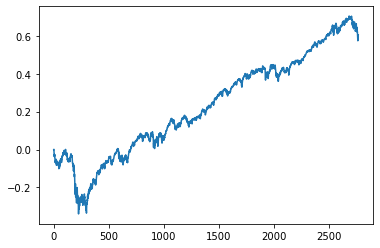

In [45]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([1,0,0,0,0,0,1])
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(EQ_env.log_return_series).cumsum().plot()

PPO policy

In [56]:

from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [57]:
config['model']['dim'] = 50
config['model']['conv_filters'] = [[16, [5, 1], 1], [32, [5, 1], 5], [16, [10, 1], 1]]

In [58]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 5000
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':50, 'start':'2008-01-02', 'end':'2018-12-31'}

In [59]:
config

{'num_workers': 1,
 'num_envs_per_worker': 1,
 'rollout_fragment_length': 20,
 'batch_mode': 'complete_episodes',
 'num_gpus': 0,
 'train_batch_size': 5000,
 'model': {'fcnet_hiddens': [100, 100],
  'fcnet_activation': 'tanh',
  'conv_filters': [[16, [5, 1], 1], [32, [5, 1], 5], [16, [10, 1], 1]],
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  '_time_major': False,
  'framestack': True,
  'dim': 50,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {'pricing_source': 'Alpaca_Equity_daily',
  'tickers': ['SPY', 'QQQ', 'SHY', 'GLD', 'TLT', 'LQD'],
  'lookback': 50,
  'start': '2008-01-02',
  'end': 

Check to see if agents can be trained

In [60]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

2020-10-19 12:58:52,033	INFO trainable.py:252 -- Trainable.setup took 79.222 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-10-19 12:58:52,034	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [61]:
for i in range(2):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_1/checkpoint-1
-0.6304444350903895


In [62]:
result

{'episode_reward_max': -0.561724132078505,
 'episode_reward_min': -0.652029927175597,
 'episode_reward_mean': -0.6075568131618514,
 'episode_len_mean': 2717.0,
 'episodes_this_iter': 2,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [-0.6076142503881217,
   -0.561724132078505,
   -0.652029927175597,
   -0.6088589430051818],
  'episode_lengths': [2717, 2717, 2717, 2717]},
 'sampler_perf': {'mean_env_wait_ms': 1.1325459108908027,
  'mean_raw_obs_processing_ms': 0.10075595122260311,
  'mean_inference_ms': 0.9959995274910309,
  'mean_action_processing_ms': 0.10824959068204312},
 'off_policy_estimator': {},
 'num_healthy_workers': 1,
 'timesteps_total': 10868,
 'timers': {'sample_time_ms': 13268.656,
  'sample_throughput': 409.537,
  'load_time_ms': 51.685,
  'load_throughput': 105137.179,
  'learn_time_ms': 1744.321,
  'learn_throughput': 3115.253,
  'update_time_ms': 2.217},
 'info': {'learner': {'def

In [49]:
agent.restore('sampleagent/checkpoint_1/checkpoint-1')

2020-10-19 11:42:27,943	INFO trainable.py:481 -- Restored on 155.198.192.44 from checkpoint: sampleagent/checkpoint_1/checkpoint-1
2020-10-19 11:42:27,944	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 14.936065912246704, '_episodes_total': 2}


In [50]:
for i in range(5):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

In [51]:
result

{'episode_reward_max': -1.4606538207848538,
 'episode_reward_min': -1.4645063547769122,
 'episode_reward_mean': -1.4626622356814447,
 'episode_len_mean': 2717.0,
 'episodes_this_iter': 2,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [-1.4636325476804446,
   -1.4626063880059572,
   -1.4630606312488108,
   -1.4633451856324962,
   -1.46218844444843,
   -1.4617151830460218,
   -1.4626371702060625,
   -1.4626367047668551,
   -1.4607733785111567,
   -1.4627215988366584,
   -1.4629789065195686,
   -1.463788392166825,
   -1.4637532287247266,
   -1.4606538207848538,
   -1.464005891906464,
   -1.4645063547769122,
   -1.461118710916315,
   -1.4635861598443032,
   -1.463104434903402,
   -1.4620578211559732,
   -1.4616518108417296,
   -1.461373642925195,
   -1.4625759648611647,
   -1.4634212836443437],
  'episode_lengths': [2717,
   2717,
   2717,
   2717,
   2717,
   2717,
   2717,
   2717,
   2717,
   2717,

SAC 

In [7]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 50
config["timesteps_per_iteration"] = 10
config["buffer_size"] = 10000

config["Q_model"]["fcnet_hiddens"] = [10, 10]
config["policy_model"]["fcnet_hiddens"] = [10, 10]
config["num_cpus_per_worker"] = 2 
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": ["QQQ", "EEM", "TLT", "SHY", "GLD", "SLV"],
    "lookback": 1,
    "start": "2007-01-02",
    "end": "2015-12-31",
}

In [15]:
# Train agent 
agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf

2020-10-18 11:25:27,401	WARNING sac_tf_policy.py:36 -- When not using a state-preprocessor with SAC, `fcnet_hiddens` will be set to an empty list! Any hidden layer sizes are defined via `policy_model.fcnet_hiddens` and `Q_model.fcnet_hiddens`.
2020-10-18 11:25:29,626	INFO trainable.py:252 -- Trainable.setup took 79.252 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-10-18 11:25:29,627	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [23]:
for i in range(20):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
    print(result['episode_reward_mean'])

-1.4620830970919299
-1.4620830970919299
-1.4620830970919299
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.462393085861623
-1.4626715012281806
-1.4626715012281806
-1.4626715012281806
-1.4626715012281806
-1.4626715012281806


In [22]:
result

{'episode_reward_max': -1.4603430197940985,
 'episode_reward_min': -1.4644678157497302,
 'episode_reward_mean': -1.4620830970919299,
 'episode_len_mean': 2717.0,
 'episodes_this_iter': 0,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [-1.4603430197940985,
   -1.4623457962025583,
   -1.4621110663130388,
   -1.4611477874002234,
   -1.4644678157497302],
  'episode_lengths': [2717, 2717, 2717, 2717, 2717]},
 'sampler_perf': {'mean_env_wait_ms': 1.429634864225194,
  'mean_raw_obs_processing_ms': 0.15369715130817593,
  'mean_inference_ms': 1.0387717205894833,
  'mean_action_processing_ms': 0.12727329722517183},
 'off_policy_estimator': {},
 'num_healthy_workers': 1,
 'timesteps_total': 15750,
 'timers': {'learn_time_ms': 4.064,
  'learn_throughput': 12301.743,
  'update_time_ms': 4.777},
 'info': {'learner': {'default_policy': {'mean_td_error': 0.28931177,
    'actor_loss': -26.91102,
    'critic_loss':

Run environment 

In [ ]:
config

In [ ]:
agent = PPOTrainer(config, Equitydaily)

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','EEM'], 'lookback':50, 'start':'2011-01-02', 'end':'2020-12-31'})

In [ ]:
agent.restore('checkpoint_1087/checkpoint-1087')

In [ ]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
pd.Series(reward_list).plot()

In [ ]:
pd.DataFrame(actions)

Run environment for RNN environment

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ'], 'lookback':50, 'start':'2018-01-02', 'end':'2020-12-31'})

state = env.reset()
done = False
cum_reward = 0 
actions = list()

rnn_state = agent.get_policy().get_initial_state()

while not done:
    action, rnn_state, _ = agent.compute_action(state,rnn_state)
    #action = np.array([1,-1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(actions)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
max_drawdown(pd.Series(env.log_return_series))

In [ ]:
annual_return(pd.Series(env.log_return_series))